# **Modelo original MNIST**

## **Llamada de librerias** y selección de cuda:0

In [ ]:
# el objetivo es crear un proceso de difusion para datos 2D
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim import Adam
import gc
from tqdm import tqdm

# barrido de memoria
gc.collect()
torch.cuda.empty_cache()

DEVICE =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## **Clase difusión:**


1.   **linear_beta_schedule(self)**: define la difusión aplicando un aumento lineal del diffusion rate entre los pasos de tiempo.
2.   **forward_diffusion(self)**: Lleva a cabo una difusión paso a paso con un único valor de ruido y da solo salida del último valor difusionado
1.   **forward_diffusion_all(self)**: Lleva a cabo una difusión paso a paso con un único valor de ruido y guarda una lista de todos los pasos de difusión.
2.   **forward_alpha(self)**: lleva a cabo la difusión en un solo paso hasta T y guarda diferentes difusiones desde t=0 hasta t=T así como los ruidos empleados.
1.   **forward_alpha_last_update(self,Time)**: mismo proceso que forward_alpha(self) solo que acepta entrada de t pensado para evaluar el modelo.
2.   **reverse_sampling(self, W,ruido,model_dict)**: lleva a cabo el proceso reverse.
  *   Al descomentar #x=ruido se puede hacer que el reverse empieze desde la distribución de entrada en la variable "ruido"
  *   W no es empleada se puede poner como None
  *   model_dict es un diccionario que almacena autoencoders para cada T con keys empezando de 0 a T-1
1.   **reverse_sampling_last_update(self, W,ruido,model_dict,Time)**: mismo proceso que la clase reverse_sampling(self, W,ruido,model_dict) pero con la posibilidad de definir el paso t del que parte el proceso reverse.
















In [ ]:

class Difusion:
    def __init__(self,data,W,paso_temp):
        self.DEVICE_dos =torch.device("cuda:0" if data.is_cuda==True else "cpu")#segun el device de la entrada me pone mi clase en cpu o en cuda tarda lo mismo o un segundo menos
        self.n=data.size(dim=0)                                                 #numero de puntos o variables
        self.m=data.size(dim=1)                                                 #numero de samples
        self.T = paso_temp                                                      #pasos de tiempo
        self.mu=0                                                               #media de el ruido que se añade en los procesos
        self.var=1                                                              #varianza del ruido
        self.data=data                                                          #dos definiciones de data para varios usos (unused)
        self.data2=data
        self.start=(1e-4)                                                       #inicio y final del difusion rate, se hace linspace para retrasar los efectos del proceso
        self.end=0.02 #0.02
        self.betas = self.linear_beta_schedule()                                #llamada interior que genera el linspace
        self.alphas = 1. - self.betas                                           #generación de las alphas
        self.alphas_cumprod = torch.from_numpy(np.cumprod(self.alphas, axis=0)).to(self.DEVICE_dos) #generación de las alphas acumulativas
        self.alpha_hat=self.alphas_cumprod                                      #cambio de nombre


    def salida_factor(self,i):
        if i>0:
          sal=self.alphas_cumprod[i-1]
        else:
          sal=None
        return self.alphas[i],self.alphas_cumprod[i],self.betas[i],sal


    def linear_beta_schedule(self):
        return np.linspace(self.start, self.end, self.T)


    def forward_alpha(self):                                                    # Paso forward con alphas acumulativas
        ruido=torch.normal(self.mu * torch.ones(self.m,self.n),self.var).to(self.DEVICE_dos)
        data2 =torch.sqrt(self.alphas_cumprod[self.T-1])*self.data2.T + (torch.sqrt(1-self.alphas_cumprod[self.T-1])*ruido)
        return data2,ruido


    def forward_alpha_last_update(self,Time):                                   #proceso forward que se empleará para entrenar tiempo a tiempo cada máquina al completo
        ruido=torch.normal(self.mu * torch.ones(self.m,self.n),self.var).to(self.DEVICE_dos)
        data2 =torch.sqrt(self.alphas_cumprod[Time-1])*self.data2.T + (torch.sqrt(1-self.alphas_cumprod[Time-1])*ruido)
        return data2,ruido


    def reverse_sampling(self, W,ruido,model_dict):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE) #sampling de una distribución normal
                #x[(x.size(dim=0)-1)]=T #ponemos el último valor como el paso de tiempo correspondiente
                #x=torch.transpose(x,0,1)
                #print(x.size())
                #x=(1/(1+torch.exp(-(x))))
                #x=0.1*x#lo que cambiamos para ir o no a los datos
                #x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                #predicted_noise=W
                predicted_noise=torch.ones(self.n).to(DEVICE)
                #for i in range(x.size(dim=0)):
                #    predicted_noise[i]=torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,:],x[:])))))-0.5                 #OJO AL CAMBIO  la matriz de pesos es ahora pixeles en las distintas filas y pesos de entrada en las distintas columnas
                #                #print(predicted_noise)
                                #print(i)
                #print(W[1,2,:].size())
                #print(x[:].size())

                for i in reversed(range(self.T)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]


                        model=model_dict[str(i)]
                        model.eval()
                        predicted_noise=model(x)



                        #for j in range(x.size(dim=0)-1):
                        #    predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)
                            #print(predicted_noise)
                            #print(i)
                        if i > 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                            #noise=noise*0.1
                            #noise = torch.zeros_like(x)
                            #noise = torch.randn_like(x) #aquí generamos el ruido antes de llamar a las clases asi que no haria falta generarlo despues, solo usar noise, o bien usar ruido_util solo que todavia no lo habremos llamado
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        x = 1 / np.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + np.sqrt(beta) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                    #no deberia ser alpha_hat?

            return x
    def reverse_sampling_time_to_time(self, W,ruido,model_dict,Time):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE) #sampling de una distribución normal
                #x[(x.size(dim=0)-1)]=T #ponemos el último valor como el paso de tiempo correspondiente
                #x=torch.transpose(x,0,1)
                #print(x.size())
                #x=(1/(1+torch.exp(-(x))))
                #x=0.1*x#lo que cambiamos para ir o no a los datos
                x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                #predicted_noise=W
                predicted_noise=torch.ones(self.n).to(DEVICE)
                #for i in range(x.size(dim=0)):
                #    predicted_noise[i]=torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,:],x[:])))))-0.5                 #OJO AL CAMBIO  la matriz de pesos es ahora pixeles en las distintas filas y pesos de entrada en las distintas columnas
                #                #print(predicted_noise)
                                #print(i)
                #print(W[1,2,:].size())
                #print(x[:].size())

                for i in reversed(range(Time)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]


                        model=model_dict[str(i)]
                        model.eval()
                        predicted_noise=model(x)



                        #for j in range(x.size(dim=0)-1):
                        #    predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)
                            #print(predicted_noise)
                            #print(i)
                        if i >= 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                            #noise=noise*0.1
                            #noise = torch.zeros_like(x)
                            #noise = torch.randn_like(x) #aquí generamos el ruido antes de llamar a las clases asi que no haria falta generarlo despues, solo usar noise, o bien usar ruido_util solo que todavia no lo habremos llamado
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        if i>0:
                            gamma=((1-self.alphas_cumprod[i-1])/(1-alpha_hat))*beta #mejor gamma para asignar nosotros el valor x_0
                        else:
                            gamma=beta
                        x = 1 / np.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + np.sqrt(gamma) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                    #no deberia ser alpha_hat?

            return x
    def reverse_sampling_espiral(self, W,ruido,model_dict):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(2),self.var).to(DEVICE) #sampling de una distribución normal
                #x[(x.size(dim=0)-1)]=T #ponemos el último valor como el paso de tiempo correspondiente
                #x=torch.transpose(x,0,1)
                #print(x.size())
                #x=(1/(1+torch.exp(-(x))))
                #x=0.1*x#lo que cambiamos para ir o no a los datos
                #x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                #predicted_noise=W
                predicted_noise=torch.ones(2).to(DEVICE)
                #for i in range(x.size(dim=0)):
                #    predicted_noise[i]=torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,:],x[:])))))-0.5                 #OJO AL CAMBIO  la matriz de pesos es ahora pixeles en las distintas filas y pesos de entrada en las distintas columnas
                #                #print(predicted_noise)
                                #print(i)
                #print(W[1,2,:].size())
                #print(x[:].size())

                for i in reversed(range(self.T)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]


                        model=model_dict[str(i)]
                        model.eval()
                        predicted_noise=model(x)



                        #for j in range(x.size(dim=0)-1):
                        #    predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)
                            #print(predicted_noise)
                            #print(i)
                        if i > 1:
                            noise= torch.normal(self.mu * torch.ones(2),self.var).to(DEVICE)
                            #noise=noise*0.1
                            #noise = torch.zeros_like(x)
                            #noise = torch.randn_like(x) #aquí generamos el ruido antes de llamar a las clases asi que no haria falta generarlo despues, solo usar noise, o bien usar ruido_util solo que todavia no lo habremos llamado
                        else:
                            noise = torch.zeros(2).to(DEVICE)
                        x = 1 / np.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + np.sqrt(beta) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                    #no deberia ser alpha_hat?

            return x
    def reverse_sampling_param(self, W,ruido,model):
            with torch.no_grad():
                x=torch.ones(self.n + 1)
                xaux=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)#sampling de una distribución normal
                x[:self.n]=xaux
                predicted_noise=torch.ones(self.n).to(DEVICE)

                for i in reversed(range(self.T)):                               #conteo inverso desde T hasta 0
                      x[self.n]=i/self.T
                      alpha = self.alphas[i]                                    #los alpha beta y alpha coump de el paso específico de la trayectoria reverse
                      alpha_hat = self.alphas_cumprod[i]
                      beta = self.betas[i]
                      #model=model_dict[str(i)]                                  #seleccionamos el modelo del paso de tiempo, es un diccionario, entra como str
                      model.eval()                                              #se pone en modo evaluación
                      predicted_noise=model(x)                                  #en el primer paso partimos del ruido y generamos una predicción de x con el modelo, luego x se redefinirá
                      if i >= 1:                                                #en todos los pasos desde T hasta 1 se genera una variable aleatoria
                          noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                      else:                                                     #en 0 no se añade más ruido
                          noise = torch.zeros(self.n).to(DEVICE)
                      gamma=beta                                                #gamma mejor empleado para sampling desde distribución normal
                      #if i>0:
                      #  gamma=((1-self.alphas_cumprod[i-1])/(1-alpha_hat))*beta#mejor gamma para asignar nosotros el valor x_0
                      xaux =((1/np.sqrt(alpha)) * (x[:self.n] -(((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise))) + (np.sqrt(gamma) * noise)
                      x[:self.n]=xaux


            return x
    def reverse_sampling_split(self, W,ruido,model_dict,split):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE) #sampling de una distribución normal
                #x[(x.size(dim=0)-1)]=T #ponemos el último valor como el paso de tiempo correspondiente
                #x=torch.transpose(x,0,1)
                #print(x.size())
                #x=(1/(1+torch.exp(-(x))))
                #x=0.1*x#lo que cambiamos para ir o no a los datos
                #x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                #predicted_noise=W
                predicted_noise=torch.ones(self.n).to(DEVICE)
                #for i in range(x.size(dim=0)):
                #    predicted_noise[i]=torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,:],x[:])))))-0.5                 #OJO AL CAMBIO  la matriz de pesos es ahora pixeles en las distintas filas y pesos de entrada en las distintas columnas
                #                #print(predicted_noise)
                                #print(i)
                #print(W[1,2,:].size())
                #print(x[:].size())

                for j in reversed(range(int(self.T/split))):
                        i=j*split
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]


                        model=model_dict[str(i)]
                        model.eval()
                        predicted_noise=model(x)



                        #for j in range(x.size(dim=0)-1):
                        #    predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)
                            #print(predicted_noise)
                            #print(i)
                        if i > 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                            #noise=noise*0.1
                            #noise = torch.zeros_like(x)
                            #noise = torch.randn_like(x) #aquí generamos el ruido antes de llamar a las clases asi que no haria falta generarlo despues, solo usar noise, o bien usar ruido_util solo que todavia no lo habremos llamado
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        x = 1 / np.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + np.sqrt(beta) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                    #no deberia ser alpha_hat?

            return x

## **Data handling**
Los datos se cargan de los ficheros './images_train.csv' y './labels_train.csv' luego son clasificados para extraer los correspondientes a los labels=1

In [ ]:
def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

train_data, train_labels = read_data('./images_train.csv', './labels_train.csv')
test_data, test_labels = read_data('./images_test.csv', './labels_test.csv')

data_bien=torch.from_numpy(train_data).float()                                 #definimos nuestras variables de data originales ojo que son [sample,data]
test_bien=torch.from_numpy(test_data).float()

data_bien=((torch.transpose(data_bien,0,1)/255)*2-1)                           #pongo e dataset linealmente entre -0.5 y 0.5
test_bien=((torch.transpose(test_bien,0,1)/255)*2-1)

data_bien = data_bien[:,np.where((train_labels==1)|(train_labels==3))[0]]      #selecciono solo los samples de 1
test_bien = test_bien[:,np.where((test_labels==1)|(test_labels==3))[0]]

data_mean = torch.mean(data_bien)                                              #almaceno la media como variable
data_bien = (data_bien - data_mean)                                            #resto la media a mi dataset para que la difusión se realice desde un punto más cercano al centro de masas de los valores
test_bien = (test_bien - data_mean)



torch.Size([60000, 784])


Los datos se reducen ya que toman valores entre 0 y 255 se les resta 0.5 por procesos anteriores y se centran alrededor de la media para permitir que la difusión sea homogenea.

In [ ]:

print(np.where(train_labels==1)[0])
print(data_bien.size())
print(test_bien.size())

data_bien=data_bien[:,:12500]                                                   #acorto el tamaño del dataset total aprox 6100 train y 1200 test
test_bien=test_bien[:,:2100]
print(data_bien.size())


torch.Size([784, 6742])
torch.Size([784, 6742])
torch.Size([784, 5000])


Ahora definimos T para todo el modelo:

In [ ]:
T=1000

## **Difusión**:
Haremos la difusión de los datos de MNIST con solo valores de 1 y guardaremos en las matrices X e Y todos los pasos de T de todas las samples en las dimensiones X(T=1000,samples=5000,data=784).
  * En forward_alpha el tiempo tene que entrar entre 1 y T
Aquí se podría usar mejor forward_alpha_last_update para no llamar a la clase dentro del for

In [ ]:
ruido=torch.ones(T,data_bien.size(dim=1),data_bien.size(dim=0))
X=torch.ones(T,data_bien.size(dim=1),data_bien.size(dim=0))

user1=Difusion(torch.clone(data_bien),None,T)
for j in range(1,T+1): #j entra como el tiempo pero habra que restarle uno para usarlo como indice
    print('vamos por: ',j)
    # for i in range(data_bien.size(dim=1)):
        #print('vamos por: ',i)

        #forward_result ,ruido_util_itera= user1.forward_diffusion()
    forward_alpha_result, ruido_util = user1.forward_alpha_last_update(j)
        #print(forward_result.size())
    X[j-1,:,:data_bien.size(dim=0)]=forward_alpha_result[:]
    #X[j-1,:,data_bien.size(dim=0)]=j
    ruido[j-1,:,:data_bien.size(dim=0)]=ruido_util[:]
    #ruido[j-1,:,data_bien.size(dim=0)]=j

#ahora X y ruido me almacenan los distintos pasos de tiempo en los distintos j con los distintos ruidos a cada paso de tiempo PERO para luego el reverse al ser forward alpha no cuadra muy bien¿?
print(ruido.size())
print(X.size())
ruido=torch.reshape(ruido,[T,data_bien.size(dim=1),data_bien.size(dim=0)])
X=torch.reshape(X,[T,data_bien.size(dim=1),data_bien.size(dim=0)])
print(ruido.size())
print(X.size())
#print(X)
Y=ruido
#permut=torch.randperm(X.size(0))
#print(permut.size())
#x_preshuffle=X
#X=X[permut,:,:] #al estar comentado no estamos mezclando los samples
#Y=Y[permut,:,:]


    #

vamos por:  1
vamos por:  2
vamos por:  3
vamos por:  4
vamos por:  5
vamos por:  6
vamos por:  7
vamos por:  8
vamos por:  9
vamos por:  10
torch.Size([10, 5000, 784])
torch.Size([10, 5000, 784])
torch.Size([10, 5000, 784])
torch.Size([10, 5000, 784])


## **Visualización**:

Para el sample 1 distribución original:

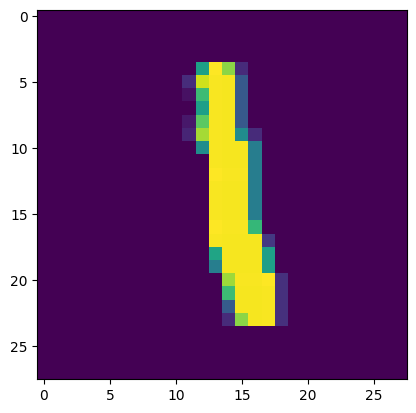

In [ ]:
plt.imshow(np.transpose(data_bien[:784,1].reshape(28,28)))

Distribución en el último paso de difusión:

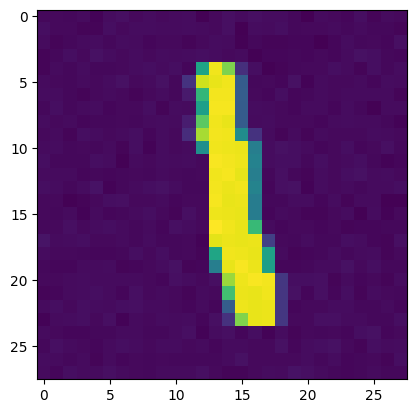

In [ ]:
plt.imshow(np.transpose(X[j-1,1,:784].reshape(28,28)))

Ruido empleado:

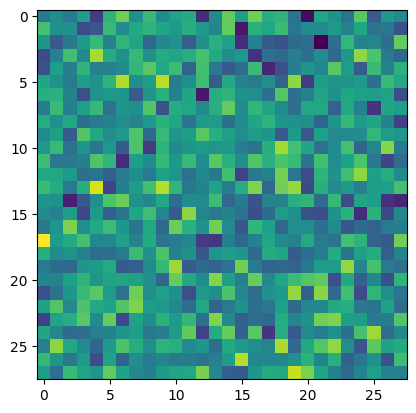

In [ ]:
plt.imshow(np.transpose(ruido[j-1,1,:784].reshape(28,28)))

Comprobamos la distribución

In [ ]:
plt.figure(dpi=100)
plt.hist(X[j-1,1,:784].cpu().numpy(),bins=40,density=True)
xr = np.linspace(-0.4,0.4,100)
sig=0.1
plt.plot(xr,1/(2*np.pi*sig**2)**0.5*np.exp(-xr*xr*0.5/sig**2))
plt.yscale('log')

Podemos comprobar los valores máximos de nuestras matrices:

In [ ]:
#print(torch.max(ruido[:784,1,T-1]-(X[:784,1,T-1])))#son muy parecidos mucha disfusión? Sí a menor paso de t mejor por eso hay que entrenar t como parámetro
print(torch.max(ruido))
print(torch.max(X))
#print(torch.min(ruido[:784,1,T-1]-(X[:784,1,T-1])))#son muy parecidos mucha disfusión? Sí a menor paso de t mejor por eso hay que entrenar t como parámetro
print(torch.min(ruido))
print(torch.min(X))

tensor(0.5566)
tensor(7.7642)
tensor(-0.5766)
tensor(-0.6180)


## **Modelo y entrenamiento**:
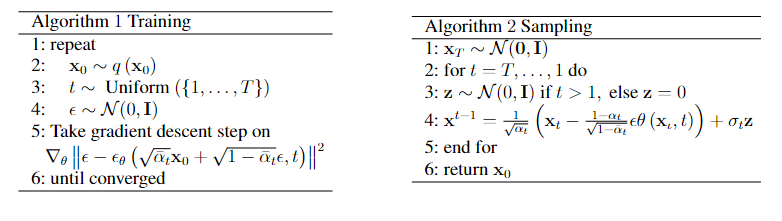



ϵθ se trata del modelo que vamos a entrenar el cual depende de dos entradas:
  * Los datos en un estado de difusión t
  * t

La dependencia en los datos difusionados la vamos a entrenar a través de un autoencoder con una cantidad de hidden variables que podremos cambiar para estudiar cual es la más conveniente, tomaremos la loss como la MSE entre ϵ(el ruido original empleado para difusionar los datos t es decir, Y) y la salida del modelo aplcado a los datos difusos, X. La dependencia en t se aplicará construyendo un diccionario con un autoencoder para cada paso de tiempo.

Parámetros de entrenamiento

In [ ]:

x_util=torch.ones(data_bien.size(dim=1),data_bien.size(dim=0))                  #predefino las variables d1el entrenamiento
x_test=torch.ones(test_bien.size(dim=1),test_bien.size(dim=0))
y_util=torch.ones(data_bien.size(dim=1),data_bien.size(dim=0))
y_test=torch.ones(test_bien.size(dim=1),test_bien.size(dim=0))

x_util=x_util.to(DEVICE)                                                        #las defino en cuda
x_test=x_test.to(DEVICE)
y_util=y_util.to(DEVICE)
y_test=y_test.to(DEVICE)

train_data=1                                                                    #libero memoria
train_labels=1
test_data=1
test_labels=1
del test_data
del test_labels
del train_data
del train_labels
gc.collect()

"""Definiciones del entrenamiento"""

errores = 10                                                                    #variable de ruptura del while
learning_rate = 0.0001                                                          #usando adam no tendrá mayor rol
batch=50

frame_num= 300                                                                  #cantidad de toma de datos totales
train_gap=1                                                                     #variable del numero de frames entre toma de datos
array_images=torch.ones(frame_num,784)

chuleta_mins=np.loadtxt('chuleta_min')                                          #carga de mínimos

pixel_bar=torch.cuda.mem_get_info(DEVICE)[1]                                    #crea una barra de carga con el total de la memoria de cuda
p_bar=tqdm(total=pixel_bar)
first=0
tol=6                                                                           #define la tolerancia de la varianza
almac_er=torch.ones(tol)                                                        #almacena la loss de las últimas tres épocas
almac=0
epoch_frame=1                                                                   #si se pone 1 solo se toma las variables originles empleado para sacar más de una toma de datos a diferentes valores de hidden var o epochs
salida_ploteable=torch.ones(T,epoch_frame,frame_num*train_gap)                  #inicializamos las variables de recogida de datos de loss
salida_ploteable_test=torch.ones(T,epoch_frame,frame_num*train_gap)
var_loss_ploteable=torch.ones(T,epoch_frame,frame_num*train_gap)


Entrenamiento:
  * g tomará valores entre 0 y T, i será su versión str para poder entrar como keys del model_dict
  * Se permutan los samples entre epochs
  * Regularización del autoencoder?

In [ ]:

"""bucle de entrenamiento"""
for m in range(epoch_frame):
    D_in, H, D_out = 784, 1700+m*100, 784                                       #784 entradas, H neuronas en la capa oculta y 784 salidas.
    model_dict=torch.nn.ParameterDict()                                         #inicializamos el diccionario|probar a definir t como variable

    for i in {str(sub) for sub in range(T)}:                                    #definimos el modelo: autoencoder
        model_dict[i] = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

    user1=Difusion(torch.clone(data_bien).to(DEVICE) ,None,T)                   #dos usuarios de la clase difusión uno para el training y otro para test
    user2=Difusion(torch.clone(test_bien).to(DEVICE) ,None,T)
    l=[]                                                                        #l almacenará la loss
    enumerador=0
    loss_c=(nn.MSELoss(reduction='mean'))#/batch                                #defino mi función loss

    for g in range(T):  #T-901,T-900                                            #inicio del bucle de T
        i=str(g)                                                                #i será mi esntrada para el diccionario
        print('esto es g =',g)
        errores = 10
        epoch = 1                                                               #inicializo las epocas antes del while
        if g==4:
             learning_rate=learning_rate*2
        # if g==20:
        #     frame_num=frame_num/2
        model=model_dict[i]                                                     #doy el valor del diccionario con entrada i a una variable
        model=model.to(DEVICE)                                                  #y lo mando a cuda
        optimizer = Adam(model.parameters(),lr=learning_rate)                   #inicializo adam en cada T
        model.train()                                                           #revisar
        cont=0                                                                  #inicializo la variable que dará entrada a la dimensión temporal de las variables de salida
        while errores>0 and epoch<=frame_num*train_gap:                         #bucle de entrenamiento que se mantiene por un valor de errores o por el número de épocas
            l=[]
            l_test=[]

            permut=torch.randperm(x_util.size(0))                               #hago una permuta aleatoria de training y test
            permut_=torch.randperm(x_test.size(0))
            forward_alpha_result, ruido_util = user1.forward_alpha_last_update(int(i)+1)            #disfusiono hasta el paso i
            forward_alpha_result_test, ruido_util_test = user2.forward_alpha_last_update(int(i)+1)

            x_util[:,:data_bien.size(dim=0)]=forward_alpha_result[permut,:]     #asocio las salidas con la variable útil en los índices random, se trata de el estado x_t
            forward_alpha_result=1                                              #borro de la memoria
            x_test[:,:data_bien.size(dim=0)]=forward_alpha_result_test[permut_,:]                   #aqui metemos los tests
            forward_alpha_result_test=1                                         #borro de la memoria

            y_util[:,:data_bien.size(dim=0)]=ruido_util[permut,:]               #asocio las salidas con la variable útil en los índices random, se trata del ruido empleado
            ruido_util=1                                                        #borro de la memoria
            y_test[:,:data_bien.size(dim=0)]=ruido_util_test[permut_,:]         #aqui metemos los tests
            ruido_util_test=1 #para descargar la RAM                            #borro de la memoria

            permut=1                                                            #borro de la memoria
            permut_=1

            for j in range(int(x_util.size(dim=0)/batch)):

                beta,alpha,alpha_hat,alpha_hat_anterior = user1.salida_factor(int(i))                #defino mi loss
                if g==0:
                  sigma=beta
                else:
                  sigma=((1-alpha_hat_anterior)/(1-alpha_hat))*beta
                loss=((beta**2)/(2*(sigma**2)*alpha*(1-alpha_hat)))*loss_c(model(x_util[range((j*batch),((j*batch)+batch)),:]),y_util[range((j*batch),((j*batch)+batch)),:])  #((beta**2)/(2*(sigma**2)*alpha*(1-alpha_hat)))*
                #loss=loss_c(model(x_util[range((j*batch),((j*batch)+batch)),:]),y_util[range((j*batch),((j*batch)+batch)),:])

                optimizer.zero_grad()                                           #paso backward
                loss.backward()
                optimizer.step()                                                #actualización de los pesos

            loss_=loss_c(model(x_util).detach(),y_util).cpu()                   #guardo la loss despues de ver el modelo toda la data
            loss_test=loss_c(model(x_test).detach(),y_test).cpu()
            gc.collect()                                                        #limpio cache

            almac_er[almac]=loss_test.detach()                                  #almaceno la loss y hago la varianza de las 3 últimas medidas
            almac=almac+1
            print(cont)

            if almac==tol:

                almac=0
            if cont>=5:
                var_loss_ploteable[int(i),m,cont]=abs(torch.var(almac_er))
            salida_ploteable[int(i),m,cont]=loss_.detach()
            salida_ploteable_test[int(i),m,cont]=loss_test.detach()
            print('el bueno',loss_)
            cont=cont+1
            #if cont>30 and int(i)>10 and cont<950:
            #    print(var_loss_ploteable[int(i),m,cont-1])
            #    if var_loss_ploteable[int(i),m,cont-1]<1e-11:
            #        errores=0
            #if chuleta_mins[g]==cont-1:                                        #analiza la entrada de chuleta_min
            #     errores=0
            if abs(loss_)<0.00000006:                                           #da una tolerancia a la loss
                errores=0
            epoch=epoch+1


        if first==0:                                                            #me da el uso de memoria de cuda
            pixel_bar=torch.cuda.mem_get_info(DEVICE)[0]
            p_bar.update(torch.cuda.mem_get_info(DEVICE)[1]-pixel_bar)
            prev=torch.cuda.mem_get_info(DEVICE)[0]
            first=1
        pixel_bar=torch.cuda.mem_get_info(DEVICE)[0]
        p_bar.update(prev-pixel_bar)
        prev=torch.cuda.mem_get_info(DEVICE)[0]

        gc.collect()

        model_dict[i]=model.cpu()                                               #guardo mi entreno  en una entrada del diccionario
        print(int(i))
        print('while: ',enumerador)
        enumerador=enumerador+1
    #del model
    #torch.cuda.empty_cache()

p_bar.close()                                                                   #cierro la barra de memoria de cuda



el bueno tensor(5.0013, device='cuda:0', grad_fn=<AddBackward0>)
0
while:  0
el bueno tensor(4.9983, device='cuda:0', grad_fn=<AddBackward0>)
1
while:  1
el bueno tensor(5.0050, device='cuda:0', grad_fn=<AddBackward0>)
2
while:  2
el bueno tensor(4.9963, device='cuda:0', grad_fn=<AddBackward0>)
3
while:  3
el bueno tensor(4.9963, device='cuda:0', grad_fn=<AddBackward0>)
4
while:  4
el bueno tensor(5.0006, device='cuda:0', grad_fn=<AddBackward0>)
5
while:  5
el bueno tensor(4.9930, device='cuda:0', grad_fn=<AddBackward0>)
6
while:  6
el bueno tensor(4.9979, device='cuda:0', grad_fn=<AddBackward0>)
7
while:  7
el bueno tensor(5.0003, device='cuda:0', grad_fn=<AddBackward0>)
8
while:  8
el bueno tensor(4.9990, device='cuda:0', grad_fn=<AddBackward0>)
9
while:  9


## **Evaluación**:

### Salvamos el modelo:

In [ ]:

"""Representaciones gráficas y salida de variables"""
plt.figure()
for i in range(epoch_frame):
    plt.plot(salida_ploteable[0,i,:].detach().cpu().numpy())
    plt.plot(salida_ploteable_test[0,i,:].detach().cpu().numpy(),'--')
plt.ylabel('loss de todas las sample/batch')
plt.xlabel('epochs')
#plt.xscale('log')
plt.show()
plt.savefig('plot_loss')

from datetime import date
from datetime import datetime

#Día actual
today = date.today()

#Fecha actual
now = datetime.now()

print(today)
print(now)
#print(W)
today.strftime('%m/%d/%Y')
now.strftime('%m_%d_%Y_%H_%M_%S')
print(now)
nombre_test='salida_ploteable_test'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
nombre_sample='salida_ploteable'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
nombre_var='var_loss_ploteable'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
torch.save(salida_ploteable_test.detach().cpu(),nombre_test) #lo pongo al fondo mejor por si falla
torch.save(salida_ploteable.detach().cpu(),nombre_sample)
torch.save(var_loss_ploteable.detach().cpu(),nombre_var)

nombre='dict'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
torch.save(model_dict.cpu(),nombre) #para salvar el modelo
#torch.save(X.cpu(),'estados_difusos') #para salvar la muestra de data


Cargar modelo

In [ ]:
model_dict=torch.load('dict_05_15_2024_13_20_12')

### Representamos el reverse desde una distribución gaussiana:

In [ ]:
samplenum=1
user1=Difusion(torch.clone(data_bien),None,T)
salida_sampled = user1.reverse_sampling(None,None,model_dict.to(DEVICE))

plt.imshow(np.transpose(salida_sampled[:784].cpu().reshape(28,28)))

Histograma de los datos de salida tras el reverse

In [ ]:
plt.figure(dpi=100)
plt.hist(salida_sampled[:784].cpu().numpy(),bins=40)

Guardamos imágenes de:
  * hist1: reverse
  * hist2: histograma del reverse
  * hist3: histograma de los datos originales
  * hist4: data original

In [ ]:
plt.figure(dpi=100)
plt.imshow(np.transpose(salida_sampled[:784].cpu().reshape(28,28)))
plt.savefig('hist1')
plt.figure(dpi=100)
plt.hist(salida_sampled[:784].cpu().numpy(),bins=40)
plt.savefig('hist2')
plt.figure(dpi=100)
plt.hist(data_bien[:784,samplenum].cpu().numpy(),bins=40)
plt.savefig('hist3')
plt.figure(dpi=100)
plt.plot(data_bien[:784,:].cpu().mean(1))
plt.savefig('hist4')


### Cargar modelo con reverse a mitad de tiempos

In [ ]:

user1=Difusion(torch.clone(data_bien),None,T)
samplenum=1
aux=torch.ones(T,2,784)
salida_sampled_split = user1.reverse_sampling_split(None,None,model_dict.to(DEVICE),2)

In [ ]:
print(salida_sampled.size())
plt.figure(dpi=100)
plt.imshow(np.transpose(salida_sampled_split[:784].cpu().reshape(28,28)))

### Carga de reconstrucción de imágen difusa con 10 samples

In [ ]:
T=1000
u=840
sample=7
user1=Difusion(torch.clone(test_bien),None,T)
user2=Difusion(torch.clone(data_bien),None,T)
#import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,12,dpi=200)
ax[0].imshow(np.transpose(X[0,sample,:784].reshape(28,28)));
ax[1].imshow(np.transpose(X[u,sample,:784].reshape(28,28)));
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[2].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[3].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[4].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[5].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[6].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[7].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[8].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[9].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[10].imshow(salida_sampled.reshape(28,28).T);
salida_sampled = user1.reverse_sampling_time_to_time(None,X[u,sample,:].to(DEVICE),model_dict.to(DEVICE),int(u)+1)
ax[11].imshow(salida_sampled.reshape(28,28).T);
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")
ax[4].axis("off")
ax[5].axis("off")
ax[6].axis("off")
ax[7].axis("off")
ax[8].axis("off")
ax[9].axis("off")
ax[10].axis("off")
ax[11].axis("off")
ax[0].axis("off")
ax[0].set_title(''.join(["T=",str(u)]), fontsize=10)
#ax[3].hist(X[0,sample,:784].numpy().reshape(-1),bins=50,density=True);
#ax[3].hist((salida_sampled+torch.mean(test_bien,1)).numpy().reshape(-1),bins=50,density=True);

# **Modelo original SWISSROLL**

## **Script**:

In [ ]:
# el objetivo es crear un proceso de difusion para datos 2D
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim import Adam
#from torch import optim

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
#a.to(DEVICE)


#intentaremos crear una espiral
sample_num=20000 #6000 en el mejor caso
theta = np.linspace(0,3*np.pi,sample_num)
r = 5 + 1*theta
x=np.multiply(r,np.cos(theta)) #+ 0.2*np.random.randn(sample_num)
y=np.multiply(r,np.sin(theta)) #+ 0.2*np.random.randn(sample_num)
factor=15
data_bien=torch.tensor([x,y])/12
#print(data_bien)
plt.scatter(data_bien.numpy()[0,:],data_bien.numpy()[1,:])
# prueba de distribucion normal de torch: print(torch.normal(0 * torch.ones(2,100),1))



class Difusion:
    def __init__(self,data,W,paso_temp):
        self.DEVICE_dos =torch.device("cuda:0" if data.is_cuda==True else "cpu")
        self.n=data.size(dim=0) #numero de puntos que se quiere samplear
        self.m=data.size(dim=1)
        self.T = paso_temp   #pasos de tiempo
        self.diffusion_rate = 0.01   #para la difusión normal
        self.mu=0
        self.var=1
        self.data=data
        self.data2=data
        self.start=1e-4
        self.end=0.02
        self.betas = self.linear_beta_schedule() #llamada interior
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.from_numpy(np.cumprod(self.alphas, axis=0)).to(self.DEVICE_dos)
        self.alpha_hat=self.alphas_cumprod
    # Beta no lineal
    def linear_beta_schedule(self):
        return np.linspace(self.start, self.end, self.T)

    # Funcion para aplicar el modelo de difusion hacia adelante
    # Es el paso del forward step con el reparametrization trick
    def forward_diffusion(self):
        ruido=torch.normal(self.mu * torch.ones(self.n),self.var).to(self.DEVICE_dos)
        #ruido=0.1*ruido
        for t in range(self.T):

            self.data =(torch.sqrt(1-self.diffusion_rate)*self.data) + (torch.sqrt(self.diffusion_rate)*ruido)

        return self.data,ruido

    def forward_diffusion_all(self):
        all_data = torch.zeros((self.T+1,self.data.shape[0],self.data.shape[1]))
        all_data[0,:] = self.data[:]
        for t in range(self.T):

            self.data =(torch.sqrt(1-self.diffusion_rate)*self.data) + (torch.sqrt(self.diffusion_rate)*torch.normal(self.mu * torch.ones(2,self.n),self.var))
            all_data[t+1,:] = self.data[:]

        return all_data

    # Paso forward con alphas acumulativas
    def forward_alpha(self):
        ruido=torch.normal(self.mu * torch.ones(self.m,self.n),self.var).to(self.DEVICE_dos)#de cara a la nueva distribucion de data pongo 1 en vez de 2
        #ruido=(1/(1+torch.exp(-(ruido))))
        # ruido=0.1*ruido
        data2 =torch.sqrt(self.alphas_cumprod[self.T-1])*self.data2.T + (torch.sqrt(1-self.alphas_cumprod[self.T-1])*ruido)
        return data2,ruido


    #proceso forward que se empleará para entrenar tiempo a tiempo cada máquina al completo
    def forward_alpha_last_update(self,Time):
        ruido=torch.normal(self.mu * torch.ones(self.m,self.n),self.var).to(self.DEVICE_dos)#de cara a la nueva distribucion de data pongo 1 en vez de 2
        #ruido=(1/(1+torch.exp(-(ruido))))
        # ruido=0.1*ruido
        data2 =torch.sqrt(self.alphas_cumprod[Time-1])*self.data2.T + (torch.sqrt(1-self.alphas_cumprod[Time-1])*ruido)
        return data2,ruido
    def reverse_sampling(self, W,ruido,model_dict):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE) #sampling de una distribución normal
                x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                predicted_noise=torch.ones(self.n).to(DEVICE)

                for i in reversed(range(self.T)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]

                        model=model_dict[str(i)]
                        model=model.to(DEVICE)
                        model.eval()
                        predicted_noise=model(x)

                        if i >= 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                        model.train()
            return x

#el reverse personalizable
    def reverse_sampling_last_update(self, W,ruido,model_dict,Time):
            with torch.no_grad():
                x=torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE) #sampling de una distribución normal
                #x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                predicted_noise=torch.ones(self.n).to(DEVICE)

                for i in reversed(range(Time)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]

                        model_aux=model_dict[str(i)]
                        model_aux.eval()
                        predicted_noise=model_aux(x)

                        if i >= 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                        #x[(x.size(dim=0)-1)]=i+1 #aqui igualamos el termino del tiempo al paso por el que vamos
                        model_aux.train()

            return x



T=1000
ruido=torch.ones(T,data_bien.size(dim=1),data_bien.size(dim=0))
X=torch.ones(T,data_bien.size(dim=1),data_bien.size(dim=0))


for j in range(1,T+1): #j entra como el tiempo pero habra que restarle uno para usarlo como indice
    print('vamos por: ',j)
    # for i in range(data_bien.size(dim=1)):
        #print('vamos por: ',i)
    user1=Difusion(torch.clone(data_bien),None,j)
        #forward_result ,ruido_util_itera= user1.forward_diffusion()
    forward_alpha_result, ruido_util = user1.forward_alpha()
        #print(forward_result.size())
    X[j-1,:,:data_bien.size(dim=0)]=forward_alpha_result[:]
    #X[j-1,:,data_bien.size(dim=0)]=j
    ruido[j-1,:,:data_bien.size(dim=0)]=ruido_util[:]
    #ruido[j-1,:,data_bien.size(dim=0)]=j

#ahora X y ruido me almacenan los distintos pasos de tiempo en los distintos j con los distintos ruidos a cada paso de tiempo PERO para luego el reverse al ser forward alpha no cuadra muy bien¿?
print(ruido.size())
print(X.size())
ruido=torch.reshape(ruido,[T,data_bien.size(dim=1),data_bien.size(dim=0)])
X=torch.reshape(X,[T,data_bien.size(dim=1),data_bien.size(dim=0)])
print(ruido.size())
print(X.size())
#print(X)
Y=ruido
#permut=torch.randperm(X.size(0))
#print(permut.size())
#x_preshuffle=X
#X=X[permut,:,:] #al estar comentado no estamos mezclando los samples
#Y=Y[permut,:,:]




D_in, H, D_out = 2, 1000, 2 #784 entradas, 100 neuronas en la capa oculta y 784 salidas.
model_dict=torch.nn.ParameterDict()
#loss_dict=torch.nn.ParameterDict()
for i in {str(sub) for sub in range(T)}:
    model_dict[i] = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    )



errores = 10                             #esta variable corta el bucle while
learning_rate = 0.008                     #learning rate que se le introducira a Adam
lr_=np.linspace(learning_rate,learning_rate/2,T)
cont_aux=1
cont_print=0                             #Mide los intervalos entre toma de muestras alcanzará en valor de train_gap y se tomará una muestra del reverse
cont_aux_continuo=0                      #va a ser el que vaya dando entradas a array_images al tomar la muestra de reverse
frame_num= 30                            #cantidad de toma de datos totales
train_gap=1                              #variable del numero de frames entre toma de datos
array_images=torch.ones(frame_num,784)   #almacenará las imágenes del proceso reverse         PERTENECE A OTRA CONF
batch=100                                #batch size para el entrenamiento
image_gap=1                              #separacion de tiempo entre toma de datos
user1=Difusion(torch.clone(data_bien).to(DEVICE),None,T)
l=[]                                     #almacenará la loss final de cada epoch
x_util=torch.ones_like(X[0,:,:])         #en el entrenamiento se generarán los propios procesos forward entre cada epoch x_util y y_util almacenarán esas salidas para todas las samples
x_util=x_util.to(DEVICE)
y_util=torch.ones_like(Y[0,:,:])
y_util=y_util.to(DEVICE)
enumerador=0                             #mide los pasos de tiempo
loss_c=(nn.MSELoss(reduction='mean'))    #función loss

for g in range(T):
    learning_rate=lr_[g]
    i=str(g)
    epoch = 1
    cont_aux=1
    cont_aux_continuo=0
    model=model_dict[i].to(DEVICE)
    #if g>200:
    #     learning_rate=learning_rate/100
    optimizer = Adam(model.parameters(),lr=learning_rate)
    model.train()
    #loss=torch.to(DEVICE)
    print('et')
    while errores>0 and epoch<=frame_num*train_gap:

        error_dis=0
        l=[]
        forward_alpha_result, ruido_util = user1.forward_alpha_last_update(g+1)
        x_util[:,:data_bien.size(dim=0)]=forward_alpha_result[:].to(DEVICE)
        y_util[:,:data_bien.size(dim=0)]=ruido_util[:].to(DEVICE)

        permut=torch.randperm(x_util.size(0))
        x_util=x_util[permut,:]
        y_util=y_util[permut,:]

        for j in range(int(X.size(dim=1)/batch)):
            #ENTRENAMIENTO
            loss=loss_c(model(x_util[range((j*batch),((j*batch)+batch)),:]),y_util[range((j*batch),((j*batch)+batch)),:]) #1 porque se emplean únicamente las y

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if cont_print==0:
            print(loss)
            cont_print=0
        else:
            cont_print=cont_print+1
        if abs(loss)<0.00000006:
            errores=0
        epoch=epoch+1

    print('el bueno',loss_c(model(x_util[:,:]),y_util[:,:]).detach() )
    model_dict[i]=model.cpu()

    if cont_aux==image_gap:
        samplenum=1
        #salida_sampled = user1.reverse_sampling_last_update(None,x_util[samplenum,:].to(DEVICE),model_dict.to(DEVICE),g)
        #salida_sampled = user1.reverse_sampling(ruido[:,1],X[:,1])


        #array_images[cont_aux_continuo,:784]=salida_sampled[:784]
        cont_aux_continuo=cont_aux_continuo+1
        cont_aux=1
    else:
        cont_aux=cont_aux+1

    #el modelo siguiente se inicializa con los parámetros del anterior
    #if int(i)<T-1:
    #    model_dict[str(int(i)+1)]=model.cpu()
    print(int(i))
    print('while: ',enumerador)
    enumerador=enumerador+1


from datetime import date
from datetime import datetime

#Día actual
today = date.today()

#Fecha actual
now = datetime.now()

print(today)
print(now)
#print(W)
today.strftime('%m/%d/%Y')
now.strftime('%m_%d_%Y_%H_%M_%S')
print(now)
nombre_test='salida_ploteable_test'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
nombre_sample='salida_ploteable'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
nombre_var='var_loss_ploteable'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')


nombre='dict'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
torch.save(model_dict.cpu(),nombre) #para salvar el modelo
#torch.save(X.cpu(),'estados_difusos') #para salvar la muestra de data

# Prueba del autoencoder:

cuda:0
torch.Size([5000, 1])


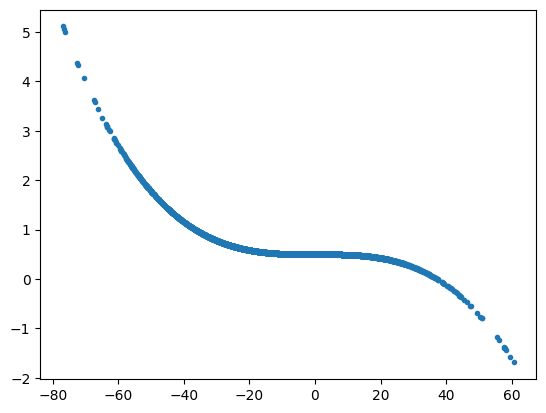

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
X = np.random.random([5000,1])*20-10
X = torch.randn(5000,1)*20-10
x_uno=X
X=X.to(DEVICE)
print(X.size())
#X=torch.from_numpy(X)
y = (0.5+0.00001*X+0.00001*X**2-0.00001*X**3)
y_uno=y.cpu()
y=y.to(DEVICE)
#y=torch.from_numpy(y)
plt.plot(X.cpu(),y.cpu(),'.')
plt.show()

In [ ]:
T=4

D_in, H, D_out = 1, 20, 1 #784 entradas, 5000 neuronas en la capa oculta y 5000 salidas.
model_dict=torch.nn.ParameterDict()
for i in {str(sub) for sub in range(T)}:
    model_dict[i] = torch.nn.Sequential( #PUEDE que haya que meter la otra variable que enumere el paso de tiempo en que nos encontramos ya que no podemos vectorizar el modelo
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    ).to(DEVICE)
#print(model)
#la llamada del modelo tendrá que ser del tipo
b=model_dict["3"]
outputs = b(-torch.randn(30,1).to(DEVICE))
outputs = b(X)
print(outputs)
#ara mandarlo a GPU
model_dict.to(DEVICE)
print(model_dict.parameters())


tensor([[ -3.5275],
        [ -1.3146],
        [ -1.9882],
        ...,
        [ -5.6076],
        [-10.5393],
        [ -2.0562]], device='cuda:0', grad_fn=<AddmmBackward0>)
<generator object Module.parameters at 0x7e17192ea5e0>


In [ ]:


errores = 10
epoch = 0
learning_rate = 0.0001 #empezar en 0.1 en bajas distancias el mejor 0,0001 con un coseno se podria tener un buen learning rate
almac_er=torch.ones(10)
tol_pass=1#mide el que la actualizacion del error se mantenga alta o cambia el learning
almac=0
cambio=0
cont_aux=1
cont_aux_continuo=0 #va a ser el que vaya dando entradas a array_images
frame_num=64 #cantidad de toma de datos totales
train_gap=10 #variable del numero de frames entre toma de datos
array_images=torch.ones(frame_num,784)
batch=10

#aux_1_X=torch.ones(T,data_bien.size(dim=0)+1,data_bien.size(dim=1))
#aux_2_W=torch.ones(T,data_bien.size(dim=0),data_bien.size(dim=1)+1)
#aux_1_X[:,:data_bien.size(dim=0),:]=X
#aux_2_W[:,:,:data_bien.size(dim=0)]=W
X=X.to(DEVICE)

#print(W.size())
#print(aux_1_X[T-1,:,1].size())

l=[]

loss_c=(nn.MSELoss(reduction='mean'))#/batch


while errores>0 and epoch<=5:
    error_dis=0

    for i in {str(sub) for sub in range(T)}:
        model=model_dict[i].to(DEVICE)
        optimizer = Adam(model.parameters(),lr=learning_rate)
        for j in range(X.size(dim=0)):
        #tenemos un diccionario de modelos para cada tiempo T al que vamos a ir llamando y entrenando por separado vectorial? STLM?                                                          #DEFINO BATCH
            #X=torch.reshape(X,[5000,1])
            #al mezclar entrenmiento y evaluacion con torch no grad se puede meter? si no quitar torch no grad
            next_prediction = model(X) #next prediction es vectorial de tamaño 1600      [:,l+j*batch]    de esta forma va a ser
            #print(next_prediction)
            #loss=-next_prediction+Y[:,range((j*batch),((j*batch)+batch)),:]
            #loss=abs(loss).mean()
            #loss=torch.square(loss)
            #print(loss)

            loss=loss_c(next_prediction,y)
            optimizer.zero_grad() #igual con el batch que ponemos no nos interesa poner a cero los parámetros hasta que no acabe el batch entero?
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            #with torch.no_grad():
            #    for param in model.parameters():
            #        param -= learning_rate*param.grad
            model_dict[i]=model
    epoch=epoch+1
    #print(loss)

    #[W,error_dis] = update_state(W.to(DEVICE), learning_rate, X.to(DEVICE).float(), Y.to(DEVICE),error_dis)#he cambiado un uno en la Y por i
        #print(i)
    print('el bueno',loss)




el bueno tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


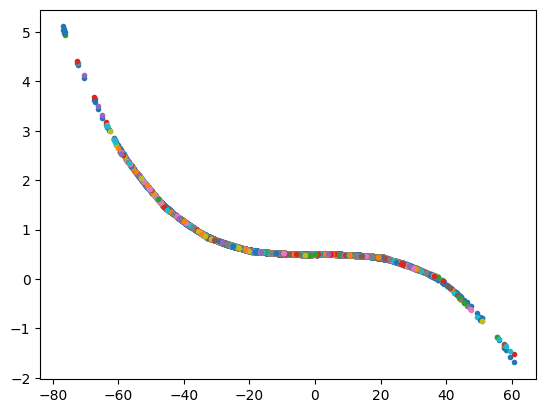

In [ ]:

model_dict.eval
for i in {str(sub) for sub in range(T)}:
    model_eval=model_dict[i]
    yy=model_eval(X)
rep_x=np.transpose(X.detach().cpu().numpy())
rep_y=np.transpose(yy.detach().cpu().numpy())
plt.plot(x_uno,y_uno.cpu(),'.')
plt.plot(rep_x,rep_y,'.')
plt.show()

torch.Size([5000, 1])


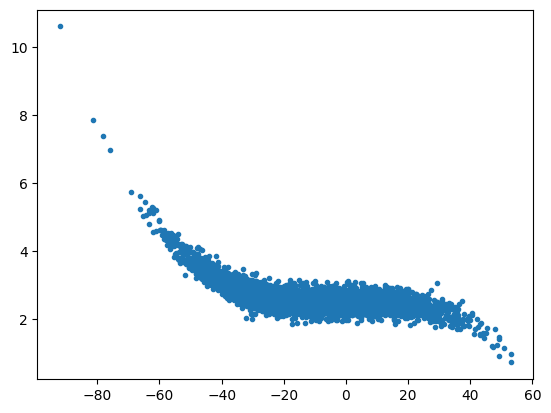

In [ ]:
X = np.random.random([5000,1])*20-10
X = torch.randn(5000,1)*20-10
X=X.to(DEVICE)
print(X.size())
#X=torch.from_numpy(X)
y = (0.5+0.00001*X+0.00001*X**2-0.00001*X**3)+ 2*torch.ones(X.shape).to(DEVICE)*torch.normal(torch.ones(size=X.shape).to(DEVICE),0.1).to(DEVICE)
#y=torch.from_numpy(y)
y=y.to(DEVICE)
plt.plot(X.cpu(),y.cpu(),'.')
plt.show()

In [ ]:
T=4

D_in, H, D_out = 1, 20, 1 #784 entradas, 5000 neuronas en la capa oculta y 5000 salidas.
model_dict=torch.nn.ParameterDict()
for i in {str(sub) for sub in range(T)}:
    model_dict[i] = torch.nn.Sequential( #PUEDE que haya que meter la otra variable que enumere el paso de tiempo en que nos encontramos ya que no podemos vectorizar el modelo
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    ).to(DEVICE)
#print(model)
#la llamada del modelo tendrá que ser del tipo
b=model_dict["3"]
outputs = b(-torch.randn(30,1).to(DEVICE))
outputs = b(X)
print(outputs)
#ara mandarlo a GPU
model_dict.to(DEVICE)
print(model_dict.parameters())

tensor([[0.7065],
        [1.2636],
        [0.7218],
        ...,
        [5.0682],
        [4.7968],
        [0.4203]], device='cuda:0', grad_fn=<AddmmBackward0>)
<generator object Module.parameters at 0x7e17192ea030>


In [ ]:


errores = 10
epoch = 0
learning_rate = 0.0001 #empezar en 0.1 en bajas distancias el mejor 0,0001 con un coseno se podria tener un buen learning rate
almac_er=torch.ones(10)
tol_pass=1#mide el que la actualizacion del error se mantenga alta o cambia el learning
almac=0
cambio=0
cont_aux=1
cont_aux_continuo=0 #va a ser el que vaya dando entradas a array_images
frame_num=64 #cantidad de toma de datos totales
train_gap=10 #variable del numero de frames entre toma de datos
array_images=torch.ones(frame_num,784)
batch=10

#aux_1_X=torch.ones(T,data_bien.size(dim=0)+1,data_bien.size(dim=1))
#aux_2_W=torch.ones(T,data_bien.size(dim=0),data_bien.size(dim=1)+1)
#aux_1_X[:,:data_bien.size(dim=0),:]=X
#aux_2_W[:,:,:data_bien.size(dim=0)]=W
X=X.to(DEVICE)

#print(W.size())
#print(aux_1_X[T-1,:,1].size())

l=[]

loss_c=(nn.MSELoss(reduction='mean'))#/batch


while errores>0 and epoch<=5:
    error_dis=0

    for i in {str(sub) for sub in range(T)}:
        model=model_dict[i].to(DEVICE)
        optimizer = Adam(model.parameters(),lr=learning_rate)
        for j in range(X.size(dim=0)):
        #tenemos un diccionario de modelos para cada tiempo T al que vamos a ir llamando y entrenando por separado vectorial? STLM?                                                          #DEFINO BATCH
            #X=torch.reshape(X,[5000,1])
            #al mezclar entrenmiento y evaluacion con torch no grad se puede meter? si no quitar torch no grad
            next_prediction = model(X) #next prediction es vectorial de tamaño 1600      [:,l+j*batch]    de esta forma va a ser
            #print(next_prediction)
            #loss=-next_prediction+Y[:,range((j*batch),((j*batch)+batch)),:]
            #loss=abs(loss).mean()
            #loss=torch.square(loss)
            #print(loss)

            loss=loss_c(next_prediction,y)
            optimizer.zero_grad() #igual con el batch que ponemos no nos interesa poner a cero los parámetros hasta que no acabe el batch entero?
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            #with torch.no_grad():
            #    for param in model.parameters():
            #        param -= learning_rate*param.grad
            model_dict[i]=model
    epoch=epoch+1
    #print(loss)

    #[W,error_dis] = update_state(W.to(DEVICE), learning_rate, X.to(DEVICE).float(), Y.to(DEVICE),error_dis)#he cambiado un uno en la Y por i
        #print(i)
    print('el bueno',loss)




el bueno tensor(0.1124, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0415, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)
el bueno tensor(0.0409, device='cuda:0', grad_fn=<MseLossBackward0>)


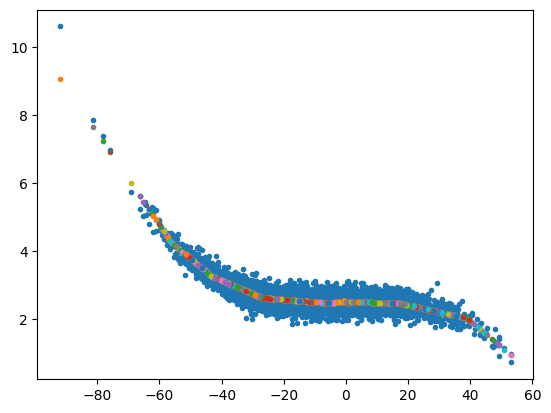

In [ ]:
model_dict.eval
for i in {str(sub) for sub in range(T)}:
    model_eval=model_dict[i]
    yy=model_eval(X)
rep_x=np.transpose(X.detach().cpu().numpy())
rep_y=np.transpose(yy.detach().cpu().numpy())
plt.plot(X.cpu(),y.cpu(),'.')
plt.plot(rep_x,rep_y,'.')
plt.show()

# Modelo lineal:

In [ ]:
# el objetivo es crear un proceso de difusion para datos 2D
import numpy as np
import torch
#import torch.nn as nn
from matplotlib import pyplot as plt
#from torch import optim
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
#a.to(DEVICE)

In [ ]:
class Difusion:
    def __init__(self,data,W,paso_temp):
        self.n=data.size(dim=0) #numero de puntos que se quiere samplear
        self.m=data.size(dim=1)
        self.T = paso_temp   #pasos de tiempo
        self.diffusion_rate = 0.01   #para la difusión normal
        self.mu=0
        self.var=1
        self.data=data
        self.data2=data
        self.start=1e-4
        self.end=0.02
        self.betas = self.linear_beta_schedule() #llamada interior
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.from_numpy(np.cumprod(self.alphas, axis=0))
        self.alpha_hat=self.alphas_cumprod
    # Beta no lineal
    def linear_beta_schedule(self):
        return np.linspace(self.start, self.end, self.T)

    # Funcion para aplicar el modelo de difusion hacia adelante
    # Es el paso del forward step con el reparametrization trick
    def forward_diffusion(self):
        ruido=torch.normal(self.mu * torch.ones(self.n),self.var)
        #ruido=0.1*ruido
        for t in range(self.T):

            self.data =(np.sqrt(1-self.diffusion_rate)*self.data) + (np.sqrt(self.diffusion_rate)*ruido)

        return self.data,ruido

    def forward_diffusion_all(self):
        all_data = np.zeros((self.T+1,self.data.shape[0],self.data.shape[1]))
        all_data[0,:] = self.data[:]
        for t in range(self.T):

            self.data =(np.sqrt(1-self.diffusion_rate)*self.data) + (np.sqrt(self.diffusion_rate)*torch.normal(self.mu * torch.ones(2,self.n),self.var))
            all_data[t+1,:] = self.data[:]

        return all_data

    # Paso forward con alphas acumulativas
    def forward_alpha(self):
        ruido=torch.normal(self.mu * torch.ones(self.n,self.m),self.var)#de cara a la nueva distribucion de data pongo 1 en vez de 2
        #ruido=(1/(1+torch.exp(-(ruido))))
        # ruido=0.1*ruido
        data2 =np.sqrt(self.alphas_cumprod[self.T-1])*self.data2 + (np.sqrt(1-self.alphas_cumprod[self.T-1])*ruido)
        return data2,ruido

    def forward_alpha_last_update(self,Time):                                   #proceso forward que se empleará para entrenar tiempo a tiempo cada máquina al completo
        ruido=torch.normal(self.mu * torch.ones(self.n,self.m),self.var)
        data2 =torch.sqrt(self.alphas_cumprod[Time-1])*self.data2 + (torch.sqrt(1-self.alphas_cumprod[Time-1])*ruido)
        return data2,ruido
    def reverse_sampling(self, W,ruido):
            with torch.no_grad():

                x=torch.normal(self.mu * torch.ones(self.n+1),self.var).to(DEVICE) #sampling de una distribución normal
                #x=torch.transpose(x,0,1)
                #print(x.size())
                #x=(1/(1+torch.exp(-(x))))
                #x=0.1*x#lo que cambiamos para ir o no a los datos
                #x=ruido #al comentar esta linea lo hacemos tomar un ruido base aleatorio si no usa la muestra característica
                #predicted_noise=W
                predicted_noise=torch.ones(self.n).to(DEVICE)
                #for i in range(x.size(dim=0)):
                #    predicted_noise[i]=torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,:],x[:])))))-0.5                 #OJO AL CAMBIO  la matriz de pesos es ahora pixeles en las distintas filas y pesos de entrada en las distintas columnas
                #                #print(predicted_noise)
                                #print(i)
                #print(W[1,2,:].size())
                #print(x[:].size())
                for i in reversed(range(self.T)):
                        alpha = self.alphas[i] #los alpha y alpha coump de el paso específico de la trayectoria reverse
                        alpha_hat = self.alphas_cumprod[i]
                        beta = self.betas[i]
                        for j in range(x.size(dim=0)-1):
                            predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)
                            #print(predicted_noise)  saliente=2*(torch.sigmoid(torch.matmul(W,x_i))-0.5)
                            #print(i)
                        if i > 1:
                            noise= torch.normal(self.mu * torch.ones(self.n),self.var).to(DEVICE)
                            noise=noise*0.1
                            #noise = torch.zeros_like(x)
                            #noise = torch.randn_like(x) #aquí generamos el ruido antes de llamar a las clases asi que no haria falta generarlo despues, solo usar noise, o bien usar ruido_util solo que todavia no lo habremos llamado
                        else:
                            noise = torch.zeros(self.n).to(DEVICE)
                        x[:(x.size(dim=0)-1)] = 1 / np.sqrt(alpha) * (x[:(x.size(dim=0)-1)] - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + np.sqrt(beta) * noise
                    #no deberia ser alpha_hat?
            return x

In [ ]:
def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

train_data, train_labels = read_data('./images_train.csv', './labels_train.csv')

x=torch.from_numpy(train_data).float()
data_bien=x
print(data_bien.size())#num muestras,dim x
data_bien=(torch.transpose(data_bien,0,1)/255)*2-1 #normalizado               HE QUITADO LA NORMALIZACIÓN

print(data_bien.size())
T=500
W=torch.rand([T,data_bien.size(dim=0),data_bien.size(dim=0)+1])/4    #OJO a donde ponemos el +1
W=W.to(DEVICE)
print(W.size())#iniciamos nuestra matriz de pesos que va a tener los pesos suficientes para cada salida para cada entrada por eso las 3 dimensiones

data_bien = data_bien[:,np.where(train_labels==1)[0]]
print(data_bien.size())
data_bien=data_bien[:,:1000]
print(data_bien.size())
                                                                                    #TIEMPO
ruido=torch.ones(T,data_bien.size(dim=0),data_bien.size(dim=1))
X=torch.ones(T,data_bien.size(dim=0),data_bien.size(dim=1))
user1=Difusion(torch.clone(data_bien),None,T)
for j in range(1,T+1): #j entra como el tiempo pero habra que restarle uno para usarlo como indice
    print('vamos por: ',j)
    forward_alpha_result, ruido_util = user1.forward_alpha_last_update(j)
    X[j-1,:,:]=forward_alpha_result[:]
    ruido[j-1,:,:]=ruido_util[:]

#ahora X y ruido me almacenan los distintos pasos de tiempo en los distintos j con los distintos ruidos a cada paso de tiempo PERO para luego el reverse al ser forward alpha no cuadra muy bien¿?
print(ruido.size())
print(X.size())
ruido=torch.reshape(ruido,[T,data_bien.size(dim=0),data_bien.size(dim=1)])
X=torch.reshape(X,[T,data_bien.size(dim=0),data_bien.size(dim=1)])
print(ruido.size())
print(X.size())
Y=ruido



In [ ]:



def predict(W, x_i):
    saliente=2*(torch.sigmoid(torch.matmul(W,x_i))-0.5) #multiplicar por factor 2 ver extension de la data
    return saliente



def update_state(W, learning_rate, x_i, y_i,error_dis):
    batch=10                                                          #DEFINO BATCH
    for j in range(int(X.size(dim=2)/batch)):
        next_prediction = predict(W, x_i[:,:,range((j*batch),((j*batch)+batch))]) #next prediction es vectorial de tamaño 1600      [:,l+j*batch]    de esta forma va a ser
        resta=2*(-next_prediction+y_i[:,:,range((j*batch),((j*batch)+batch))])
        W=W+learning_rate*(torch.matmul(resta,torch.transpose(x_i[:,:,range((j*batch),((j*batch)+batch))],1,2)))/batch    #iterar 1600 veces           AQUI he quitado los dos puntos y puesto range
        error_dis=error_dis+sum(sum(sum(abs(resta))))/(batch*T)    #podriamos quitar batch y poner el numero de pixeles
    return W, error_dis

In [ ]:
errores = 10
epoch = 0
learning_rate = 0.01                                                            #empezar en 0.1 en bajas distancias el mejor 0,0001 con un coseno se podria tener un buen learning rate
almac_er=torch.ones(10)
tol_pass=1                                                                      #mide el que la actualizacion del error se mantenga alta o cambia el learning
almac=0
cambio=0
cont_aux=1
cont_aux_continuo=0                                                             #va a ser el que vaya dando entradas a array_images
frame_num=100                                                                   #cantidad de toma de datos totales
train_gap=1                                                                     #variable del numero de frames entre toma de datos
array_images=torch.ones(frame_num,784)


aux_1_X=torch.ones(T,data_bien.size(dim=0)+1,data_bien.size(dim=1))
aux_2_W=torch.ones(T,data_bien.size(dim=0),data_bien.size(dim=1)+1)
aux_1_X[:,:data_bien.size(dim=0),:]=X

print(W.size())
print(aux_1_X[T-1,:,1].size())
user1=Difusion(torch.clone(data_bien),W,T)

while errores>0 and epoch<=frame_num*train_gap:
    error_dis=0
    forward_alpha_result, ruido_util = user1.forward_alpha_last_update(j)
    permut=torch.randperm(aux_1_X[T-1,1,:].size(0))                                       #hago una permuta aleatoria de training y test
    X[j-1,:,:]=forward_alpha_result[permut]
    ruido[j-1,:,:]=ruido_util[permut]
    Y=ruido.to(DEVICE)
    aux_1_X=torch.ones(T,data_bien.size(dim=0)+1,data_bien.size(dim=1)).to(DEVICE)
    aux_1_X[:,:data_bien.size(dim=0),:]=X.to(DEVICE)
    [W,error_dis] = update_state(W.to(DEVICE), learning_rate, aux_1_X.to(DEVICE), Y.to(DEVICE),error_dis)#he cambiado un uno en la Y por i
    print('el bueno',error_dis)

    if abs(error_dis)<0.06:
        errores=0
    epoch=epoch+1

torch.Size([500, 784, 785])
torch.Size([785])
el bueno tensor(149701., device='cuda:0')
el bueno tensor(106601.5234, device='cuda:0')
el bueno tensor(93306.1875, device='cuda:0')
el bueno tensor(87279.0078, device='cuda:0')
el bueno tensor(83927.5000, device='cuda:0')
el bueno tensor(81816.5859, device='cuda:0')
el bueno tensor(80341.8750, device='cuda:0')
el bueno tensor(79255.0781, device='cuda:0')
el bueno tensor(78409.6172, device='cuda:0')
el bueno tensor(77722.5234, device='cuda:0')
el bueno tensor(77152.5703, device='cuda:0')
el bueno tensor(76666.3359, device='cuda:0')
el bueno tensor(76244.2422, device='cuda:0')
el bueno tensor(75877.3125, device='cuda:0')
el bueno tensor(75545.2266, device='cuda:0')
el bueno tensor(75251.2969, device='cuda:0')
el bueno tensor(74981.5625, device='cuda:0')
el bueno tensor(74741.1016, device='cuda:0')
el bueno tensor(74514.6094, device='cuda:0')
el bueno tensor(74307.3906, device='cuda:0')
el bueno tensor(74111.4219, device='cuda:0')
el bueno te

In [ ]:
from datetime import date
from datetime import datetime

#Día actual
today = date.today()

#Fecha actual
now = datetime.now()

print(today)
print(now)
print(W)
today.strftime('%m/%d/%Y')
now.strftime('%m_%d_%Y_%H_%M_%S')
print(now)
nombre='pesos_batch'+'_'+now.strftime('%m_%d_%Y_%H_%M_%S')
torch.save(W,nombre)

<ipython-input-47-126b64a32a88>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_noise[j]=2*(torch.tensor(1/(1+torch.exp(-(torch.dot(W[i,j,:],x[:])))))-0.5)


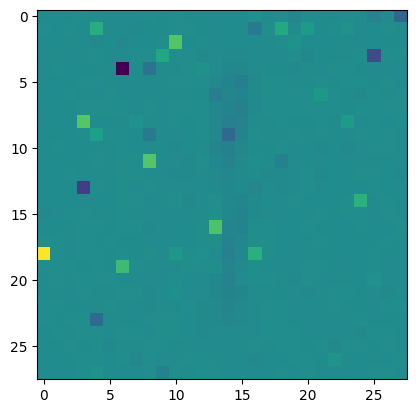

In [ ]:
samplenum=1
user1=Difusion(torch.clone(data_bien[:,:]),W,T)


salida_sampled = user1.reverse_sampling(W.to(DEVICE),X[T-1,:,samplenum].to(DEVICE))

import matplotlib.pyplot as plt
plt.imshow(np.transpose(salida_sampled[:784].cpu().float().reshape(28,28)))
A=salida_sampled

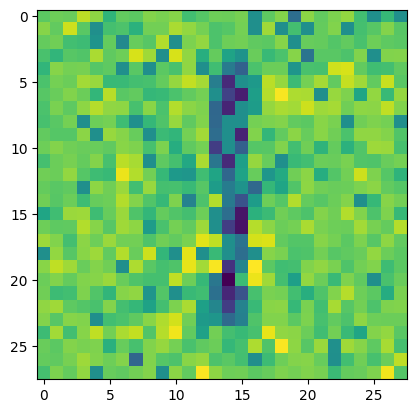

In [ ]:
plot_prueba=salida_sampled
plot_prueba[np.where(salida_sampled.float().cpu()>1)]=0
plot_prueba[np.where(salida_sampled.float().cpu()<-1)]=0
plt.imshow(np.transpose(plot_prueba[:784].cpu().reshape(28,28)))